# Challenge 2 - Semana 1

Neste Challenge, a tarefa será construir um modelo preditivo capaz de identificar a probabilidade de um cliente deixar de assinar os serviços da Novexus, uma empresa no ramo de telecomunicações. Para isso informações referentes aos clientes assinantes da plataforma e consequentemente se realizaram Churn ou não foram disponibilizados via API, fornecendo um arquivo base json.

In [138]:
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from utils.utils import plot_countplots, heatmap_corr, adicionar_estatisticas, plot_matriz_confusao
from imblearn.over_sampling import SMOTE # OVERSAMPLING




# Imports ML
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Otimizando os modelos de machine learning
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
import pickle

In [2]:
url = 'https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json'

In [3]:
response = requests.get(url)

In [4]:
data = response.json()

In [5]:
data.head()

[{'customerID': '0002-ORFBO',
  'Churn': 'No',
  'customer': {'gender': 'Female',
   'SeniorCitizen': 0,
   'Partner': 'Yes',
   'Dependents': 'Yes',
   'tenure': 9},
  'phone': {'PhoneService': 'Yes', 'MultipleLines': 'No'},
  'internet': {'InternetService': 'DSL',
   'OnlineSecurity': 'No',
   'OnlineBackup': 'Yes',
   'DeviceProtection': 'No',
   'TechSupport': 'Yes',
   'StreamingTV': 'Yes',
   'StreamingMovies': 'No'},
  'account': {'Contract': 'One year',
   'PaperlessBilling': 'Yes',
   'PaymentMethod': 'Mailed check',
   'Charges': {'Monthly': 65.6, 'Total': '593.3'}}},
 {'customerID': '0003-MKNFE',
  'Churn': 'No',
  'customer': {'gender': 'Male',
   'SeniorCitizen': 0,
   'Partner': 'No',
   'Dependents': 'No',
   'tenure': 9},
  'phone': {'PhoneService': 'Yes', 'MultipleLines': 'Yes'},
  'internet': {'InternetService': 'DSL',
   'OnlineSecurity': 'No',
   'OnlineBackup': 'No',
   'DeviceProtection': 'No',
   'TechSupport': 'No',
   'StreamingTV': 'No',
   'StreamingMovies': 

In [6]:
data = pd.json_normalize(data)

Após realizar a importação do arquivo json e verificar que ele se encontrava em uma formatação não adequada para o tratamento, foi realizado a normalização e consequentemente adaptação do arquivo json para um DataFrame padrão

In [7]:
data

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,...,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,...,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


#### Dicionário de dados

Colunas presentes no DataFrame e o significado de cada respectivamente

* `customerID`: número de identificação único de cada cliente
* `Churn`: se o cliente deixou ou não a empresa 
* `gender`: gênero (masculino e feminino) 
* `SeniorCitizen`: informação sobre um cliente ter ou não idade igual ou maior que 65 anos 
* `Partner`:  se o cliente possui ou não um parceiro ou parceira
* `Dependents`: se o cliente possui ou não dependentes
* `tenure`:  meses de contrato do cliente
* `PhoneService`: assinatura de serviço telefônico 
* `MultipleLines`: assisnatura de mais de uma linha de telefone 
* `InternetService`: assinatura de um provedor internet 
* `OnlineSecurity`: assinatura adicional de segurança online 
* `OnlineBackup`: assinatura adicional de backup online 
* `DeviceProtection`: assinatura adicional de proteção no dispositivo 
* `TechSupport`: assinatura adicional de suporte técnico, menos tempo de espera
* `StreamingTV`: assinatura de TV a cabo 
* `StreamingMovies`: assinatura de streaming de filmes 
* `Contract`: tipo de contrato
* `PaperlessBilling`: se o cliente prefere receber online a fatura
* `PaymentMethod`: forma de pagamento
* `Charges.Monthly`: total de todos os serviços do cliente por mês
* `Charges.Total`: total gasto pelo cliente

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [9]:
for col in data.columns:
    print(f'Coluna: {col}')
    print(data[col].unique())
    print('-'*30)

Coluna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Coluna: Churn
['No' 'Yes' '']
------------------------------
Coluna: customer.gender
['Female' 'Male']
------------------------------
Coluna: customer.SeniorCitizen
[0 1]
------------------------------
Coluna: customer.Partner
['Yes' 'No']
------------------------------
Coluna: customer.Dependents
['Yes' 'No']
------------------------------
Coluna: customer.tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
------------------------------
Coluna: phone.PhoneService
['Yes' 'No']
------------------------------
Coluna: phone.MultipleLines
['No' 'Yes' 'No phone service']
------------------------------
Coluna: internet.InternetService
['DSL' 'Fiber optic' 'No']
---------------------

É possível observar que não existem valores nulos entre as 7267 entradas realizadas, porém ao verificar os valores individuais por coluna, localiza-se algumas colunas com informação vazia.
Além disso, verifica-se que a coluna account.Charges.Total é do tipo object, sendo que deveria ser float64, portanto, para ser possível converter é necessário preencher as linhas vazias e posteriormente transformá-la em float.

In [10]:
data[data['account.Charges.Total'] == ' ']

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
975,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


In [11]:
data[data['account.Charges.Total'] == ' '][['customer.tenure', 'account.Contract', 'account.PaperlessBilling', 'account.Charges.Monthly', 'account.Charges.Total']]

,customer.tenure,account.Contract,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total
975,0,Two year,No,56.05,
1775,0,Two year,No,20.00,
1955,0,Two year,Yes,61.90,
2075,0,One year,Yes,19.70,
2232,0,Two year,No,20.25,
2308,0,Two year,No,25.35,
2930,0,Two year,No,73.35,
3134,0,Two year,No,25.75,
3203,0,Two year,Yes,52.55,
4169,0,Two year,No,80.85,


Verificando quais linhas do account.Charges.Total estão vazias, nota-se que o customer.tenure está indicado por 0, portanto não se é possível realizar a conta account.Charges.Monthly * customer.tenure, porém assumindo que o tenure seja equivalente ao tempo de contrato indicado, basta adicionar essa informação a linha do tenure e posteriormente o resultado da operação em Charges.Total

In [12]:
idx = data[data['account.Charges.Total'] == ' '].index
idx

Int64Index([975, 1775, 1955, 2075, 2232, 2308, 2930, 3134, 3203, 4169, 5599], dtype='int64')

In [13]:
data['account.Contract'].value_counts()

Month-to-month    4005
Two year          1743
One year          1519
Name: account.Contract, dtype: int64

In [14]:
conditions = [
    (data['account.Contract'] == 'Month-to-month'),
    (data['account.Contract'] == 'One year'),
    (data['account.Contract'] == 'Two year')
]

values = ['1', '12', '24']

In [15]:
data_backup = data.copy()
#data = data_backup.copy()

In [16]:
data.loc[idx, 'customer.tenure'] = data['account.Contract'].apply(lambda x: 12 if x == 'One year' else 24)
data.loc[idx, 'customer.tenure']

975     24
1775    24
1955    24
2075    12
2232    24
2308    24
2930    24
3134    24
3203    24
4169    24
5599    24
Name: customer.tenure, dtype: int64

In [17]:
data.loc[idx][['customer.tenure', 'account.Contract', 'account.PaperlessBilling', 'account.Charges.Monthly', 'account.Charges.Total']]

,customer.tenure,account.Contract,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total
975,24,Two year,No,56.05,
1775,24,Two year,No,20.00,
1955,24,Two year,Yes,61.90,
2075,12,One year,Yes,19.70,
2232,24,Two year,No,20.25,
2308,24,Two year,No,25.35,
2930,24,Two year,No,73.35,
3134,24,Two year,No,25.75,
3203,24,Two year,Yes,52.55,
4169,24,Two year,No,80.85,


In [18]:
data.loc[idx, 'account.Charges.Total'] = data.loc[idx, 'account.Charges.Monthly'] * data.loc[idx, 'customer.tenure']
data.loc[idx][['customer.tenure', 'account.Contract', 'account.PaperlessBilling', 'account.Charges.Monthly', 'account.Charges.Total']]

,customer.tenure,account.Contract,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total
975,24,Two year,No,56.05,1345.2
1775,24,Two year,No,20.00,480.0
1955,24,Two year,Yes,61.90,1485.6
2075,12,One year,Yes,19.70,236.4
2232,24,Two year,No,20.25,486.0
2308,24,Two year,No,25.35,608.4
2930,24,Two year,No,73.35,1760.4
3134,24,Two year,No,25.75,618.0
3203,24,Two year,Yes,52.55,1261.2
4169,24,Two year,No,80.85,1940.4


In [19]:
data['account.Charges.Total'] = data['account.Charges.Total'].astype(np.float64)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [21]:
for col in data.columns:
    print(f'Coluna: {col}')
    print(data[col].unique())
    print('-'*30)

Coluna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Coluna: Churn
['No' 'Yes' '']
------------------------------
Coluna: customer.gender
['Female' 'Male']
------------------------------
Coluna: customer.SeniorCitizen
[0 1]
------------------------------
Coluna: customer.Partner
['Yes' 'No']
------------------------------
Coluna: customer.Dependents
['Yes' 'No']
------------------------------
Coluna: customer.tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42]
------------------------------
Coluna: phone.PhoneService
['Yes' 'No']
------------------------------
Coluna: phone.MultipleLines
['No' 'Yes' 'No phone service']
------------------------------
Coluna: internet.InternetService
['DSL' 'Fiber optic' 'No']
-------------------------

Após preencher as colunas de customer.ternure e account.Charges.Total e converter a última para float64, será necessário tratar as linhas vazias encontradas na coluna do Churn. Comparando as 224 com o total de 7267, faz com que caso elas sejam desconsideradas não irá impactar de maneira expressiva o dataset e evita que seja necessário a utilização de técnicas para a determinação do Churn antes do algoritmo de aprendizado ser utilizado.

In [22]:
data.query("Churn == ''")

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
30,0047-ZHDTW,,Female,0,No,No,11,Yes,Yes,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),79.00,929.30
75,0120-YZLQA,,Male,0,No,No,71,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.90,1355.10
96,0154-QYHJU,,Male,0,No,No,29,Yes,No,DSL,...,Yes,No,Yes,No,No,One year,Yes,Electronic check,58.75,1696.20
98,0162-RZGMZ,,Female,1,No,No,5,Yes,No,DSL,...,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),59.90,287.85
175,0274-VVQOQ,,Male,1,Yes,No,65,Yes,Yes,Fiber optic,...,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),103.15,6792.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,9840-GSRFX,,Female,0,No,No,14,Yes,Yes,DSL,...,Yes,No,No,No,No,One year,Yes,Mailed check,54.25,773.20
7180,9872-RZQQB,,Female,0,Yes,No,49,No,No phone service,DSL,...,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75
7211,9920-GNDMB,,Male,0,No,No,9,Yes,Yes,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,76.25,684.85
7239,9955-RVWSC,,Female,0,Yes,Yes,67,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.25,1372.90


In [23]:
data_sem_vazio = data[data['Churn'] != ''].copy()

In [24]:
data_sem_vazio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

In [25]:
for col in data_sem_vazio.columns:
    print(f'Coluna: {col}')
    print(data_sem_vazio[col].unique())
    print('-'*30)

Coluna: customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Coluna: Churn
['No' 'Yes']
------------------------------
Coluna: customer.gender
['Female' 'Male']
------------------------------
Coluna: customer.SeniorCitizen
[0 1]
------------------------------
Coluna: customer.Partner
['Yes' 'No']
------------------------------
Coluna: customer.Dependents
['Yes' 'No']
------------------------------
Coluna: customer.tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
------------------------------
Coluna: phone.PhoneService
['Yes' 'No']
------------------------------
Coluna: phone.MultipleLines
['No' 'Yes' 'No phone service']
------------------------------
Coluna: internet.InternetService
['DSL' 'Fiber optic' 'No']
----------------------------

In [26]:
data_sem_vazio.reset_index(drop=True, inplace=True)

Posteriormente foi verificado que o dataset estava quase preparado, sem dados vazios e sem dados duplicados e com o valor de customer.tenure sem outliers aparentes.

In [27]:
data_sem_vazio.duplicated().sum()

0

In [28]:
data_sem_vazio.isna().sum()

customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64

In [29]:
data_sem_vazio.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.406929,64.761692,2281.253259
std,0.368612,24.529338,30.090047,2265.703526
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.900000
50%,0.000000,29.000000,70.350000,1396.250000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


<AxesSubplot: xlabel='customer.tenure'>

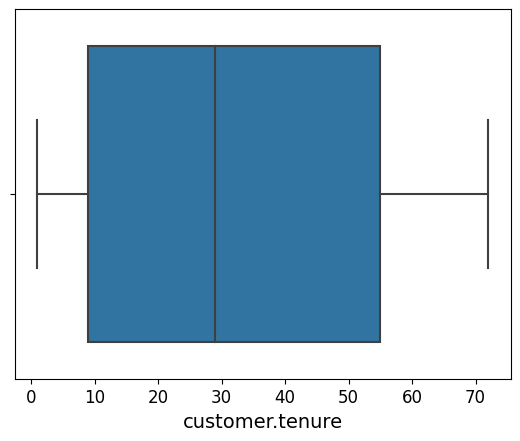

In [30]:
sns.boxplot(x=data_sem_vazio['customer.tenure'])

In [31]:
df_sem_id = data_sem_vazio.drop('customerID', axis=1).copy()

In [32]:
df_sem_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7043 non-null   object 
 1   customer.gender            7043 non-null   object 
 2   customer.SeniorCitizen     7043 non-null   int64  
 3   customer.Partner           7043 non-null   object 
 4   customer.Dependents        7043 non-null   object 
 5   customer.tenure            7043 non-null   int64  
 6   phone.PhoneService         7043 non-null   object 
 7   phone.MultipleLines        7043 non-null   object 
 8   internet.InternetService   7043 non-null   object 
 9   internet.OnlineSecurity    7043 non-null   object 
 10  internet.OnlineBackup      7043 non-null   object 
 11  internet.DeviceProtection  7043 non-null   object 
 12  internet.TechSupport       7043 non-null   object 
 13  internet.StreamingTV       7043 non-null   objec

In [33]:
for col in df_sem_id.columns:
    print(f'Coluna: {col}')
    print(df_sem_id[col].unique())
    print('-'*30)

Coluna: Churn
['No' 'Yes']
------------------------------
Coluna: customer.gender
['Female' 'Male']
------------------------------
Coluna: customer.SeniorCitizen
[0 1]
------------------------------
Coluna: customer.Partner
['Yes' 'No']
------------------------------
Coluna: customer.Dependents
['Yes' 'No']
------------------------------
Coluna: customer.tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
------------------------------
Coluna: phone.PhoneService
['Yes' 'No']
------------------------------
Coluna: phone.MultipleLines
['No' 'Yes' 'No phone service']
------------------------------
Coluna: internet.InternetService
['DSL' 'Fiber optic' 'No']
------------------------------
Coluna: internet.OnlineSecurity
['No' 'Yes' 'No internet service']
------------------------------
Coluna: internet.OnlineBackup
['Ye

# Representação gráfica dos dados

Com o tratamento inicial já é possível buscar uma visualização gráfica das informações fornecidas pelos dados, com o objetivo de visualizar padrões ou comportamentos.

In [34]:
palette = ["#171821", "#F10040", "#ff7131", "#fe3d67"]
palette

['#171821', '#F10040', '#ff7131', '#fe3d67']

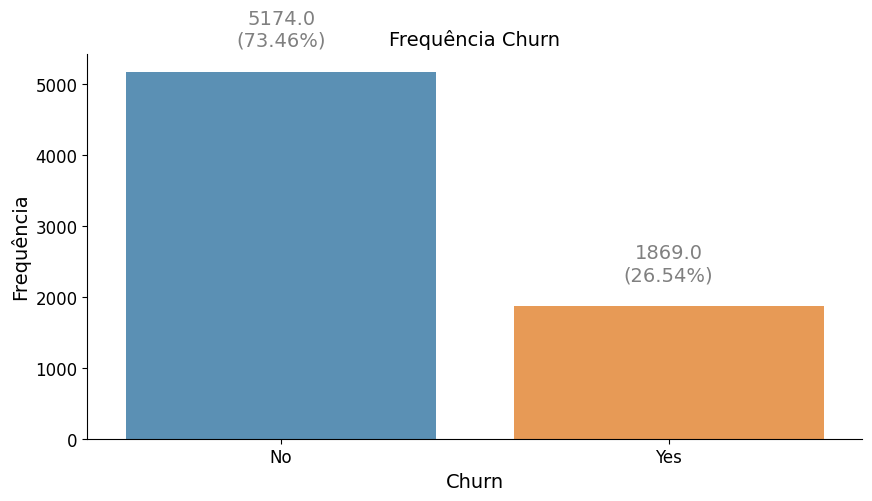

In [35]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=df_sem_id, x='Churn', alpha=.8)
#sns.color_palette("Paired", as_cmap=True)
sns.color_palette(palette=palette, as_cmap=True)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.title('Frequência Churn')
ax.set(xticklabels=["No", "Yes"]);
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{y}\n({y/len(df_sem_id)*100:.2f}%)\n', (x, y),
                ha='center', va='bottom', color='gray')
plt.show()

In [36]:
df_sem_id['Churn'].value_counts(normalize=True).round(3)*100

No     73.5
Yes    26.5
Name: Churn, dtype: float64

A representação da negativa em relação ao Churn é bem superior a positiva no banco de dados analisado, dessa maneira, a amostragem utilizada para o treinamento do algoritmo pode acabar sendo enviesado, e portanto tendencioso para a negativa.

In [37]:
grupo_customer = df_sem_id.filter(like='customer').columns.tolist()[0:-1]
grupo_customer

['customer.gender',
 'customer.SeniorCitizen',
 'customer.Partner',
 'customer.Dependents']

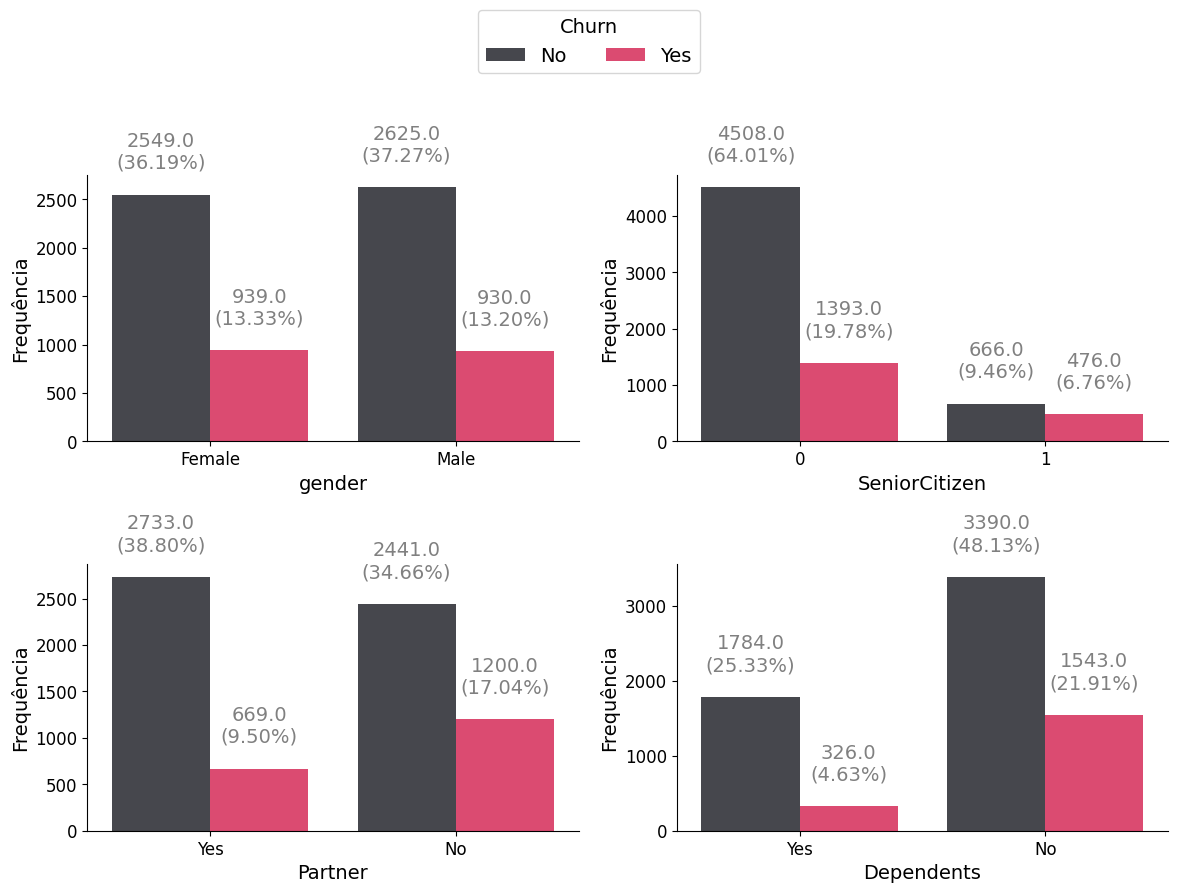

In [38]:
ax = plot_countplots(df_sem_id, 'Churn', grupo_customer)

In [39]:
grupo_phone = df_sem_id.filter(like='phone').columns.tolist()
grupo_phone

['phone.PhoneService', 'phone.MultipleLines']

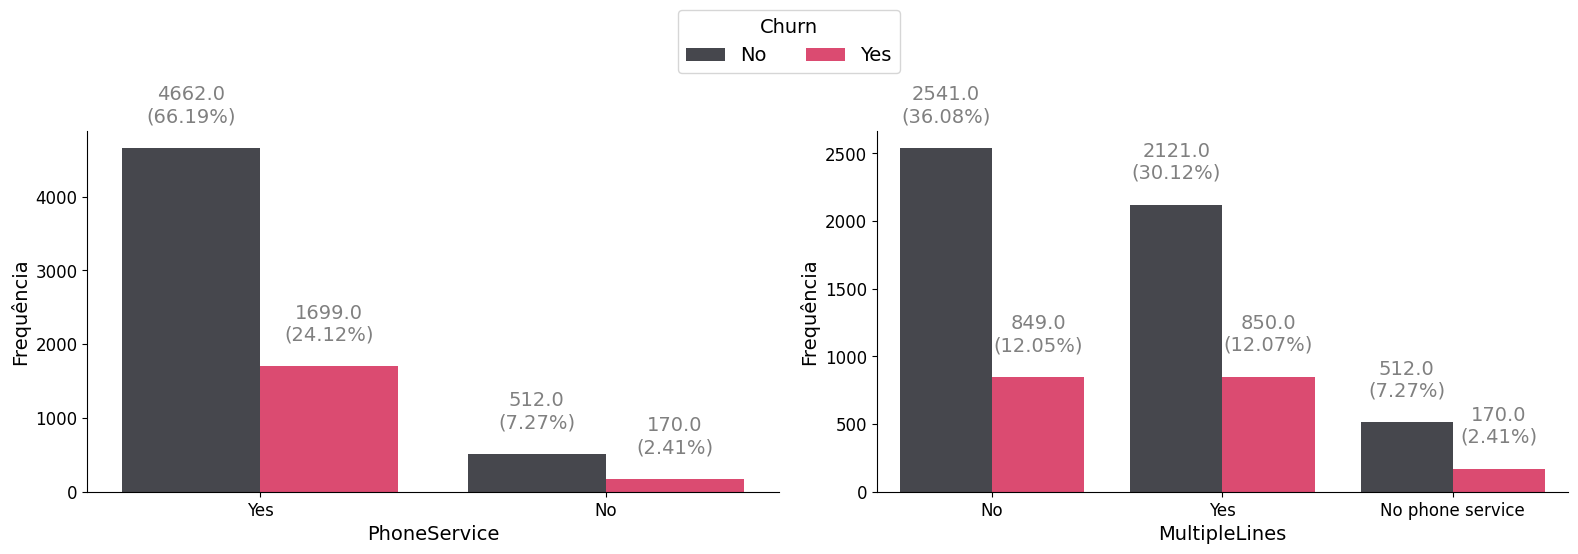

In [40]:
plot_countplots(df_sem_id, 'Churn', grupo_phone, figsize=(16,5))

In [41]:
grupo_internet = df_sem_id.filter(like='internet').columns.tolist()
grupo_internet

['internet.InternetService',
 'internet.OnlineSecurity',
 'internet.OnlineBackup',
 'internet.DeviceProtection',
 'internet.TechSupport',
 'internet.StreamingTV',
 'internet.StreamingMovies']

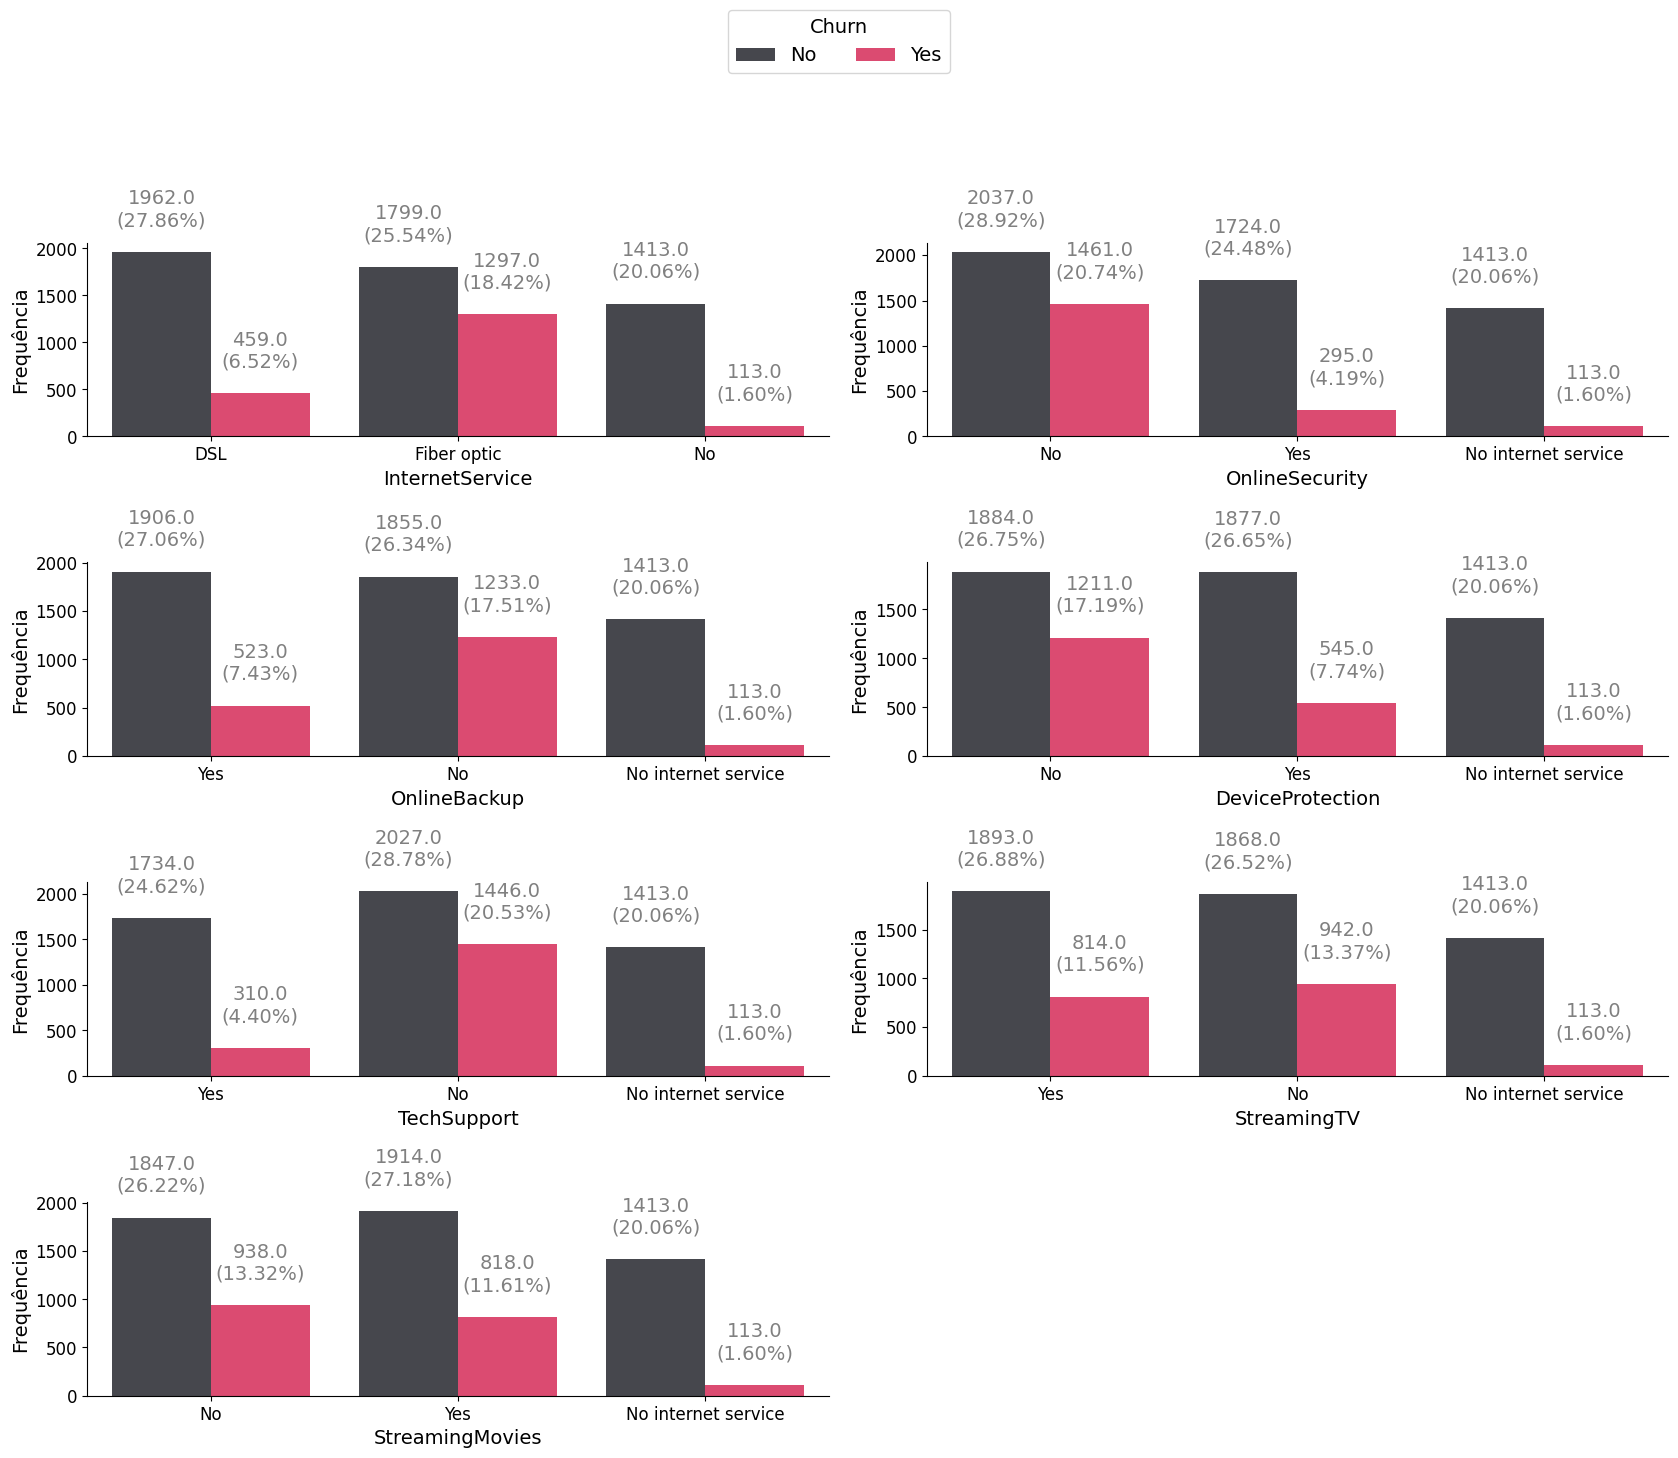

In [42]:
plot_countplots(df_sem_id, 'Churn', grupo_internet, figsize=(17,13))

In [43]:
grupo_account = df_sem_id.filter(like='account').columns.tolist()[:-2]
grupo_account

['account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod']

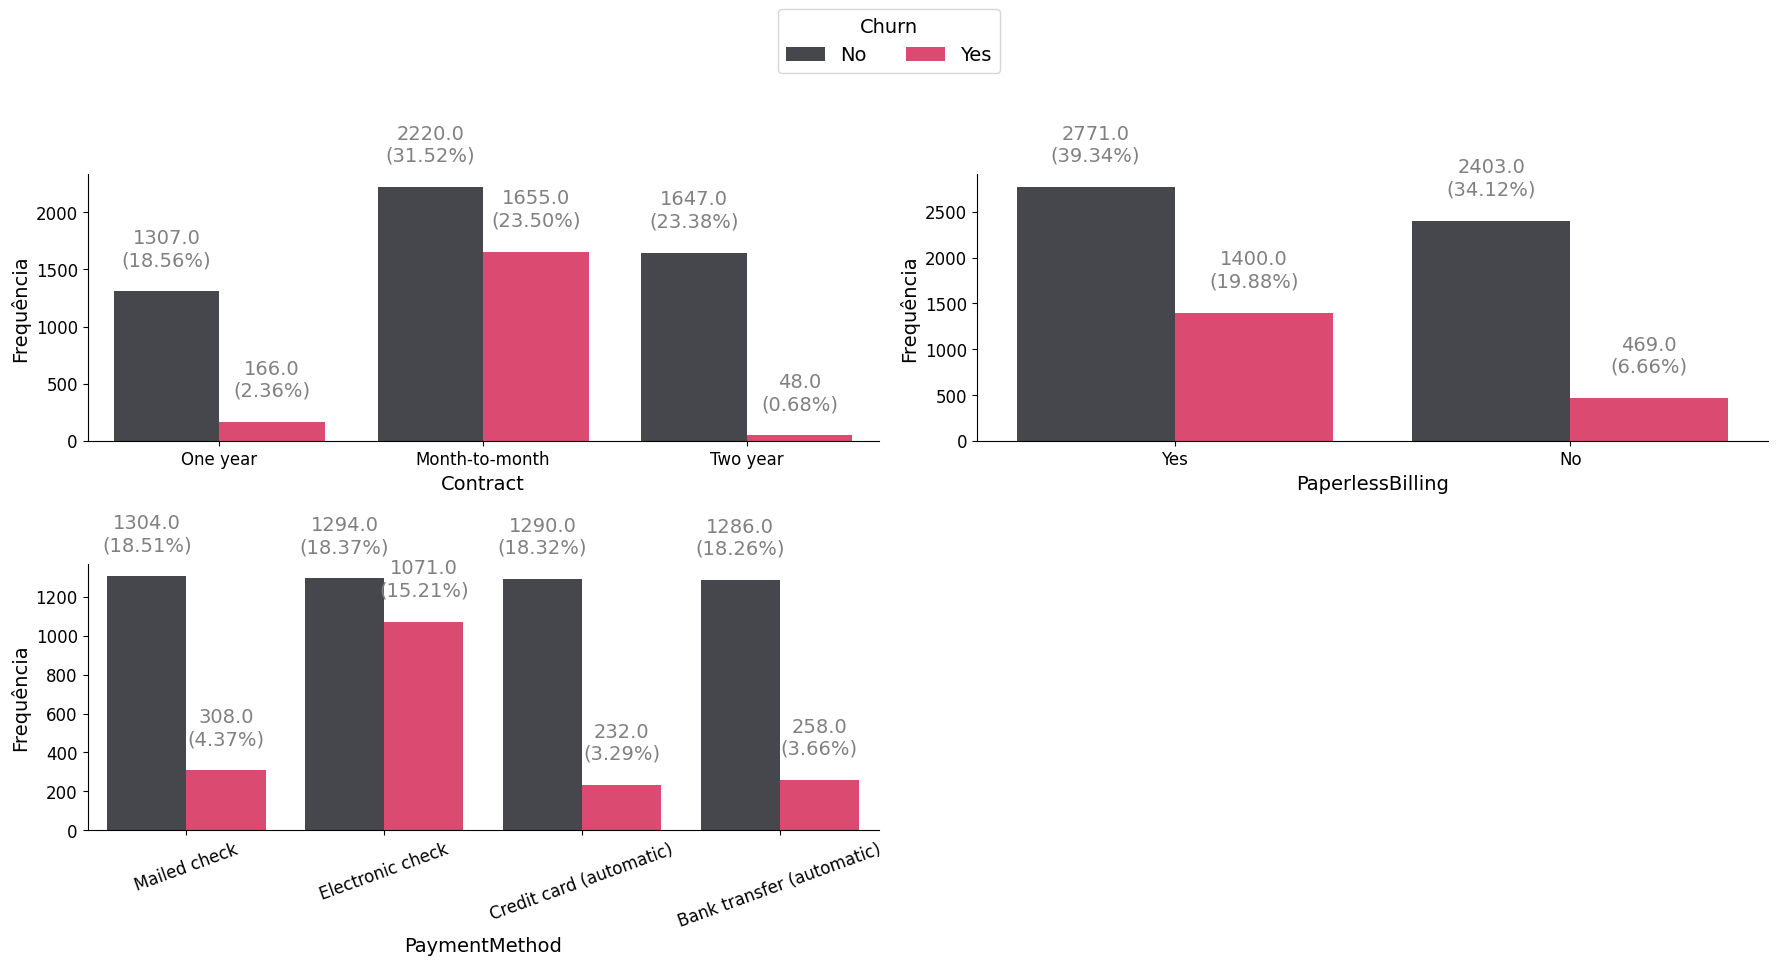

In [44]:
plot_countplots(df_sem_id, 'Churn', grupo_account, figsize=(18, 8))
plt.xticks(rotation=20)
plt.show()

Insights preliminares:

* `SeniorCitizen`: Apesar da presença de poucos dados para pessoas não consideradas seniores, é possível concluir que pessoas com 65 anos ou mais tendem a não cancelar seus planos, de modo bem mais expressivos.
* `PhoneService` e `MultipleLines`: Ambos indicam que dentre os cancelamentos a maior parcela são de pessoas que possuem pelo menos uma linha de telefone
* `Contract`: Apresenta forte correlação do tempo de contrato com a realização do cancelamento, sendo que contratos mais curtos o maior responsável pelos cancelamentos.

A grande maioria das colunas não apresentam correlações representativas com a realização do Churn e algumas algumas demonstram comportamentos bem semelhantes, sendo um indicativo de que talvez seja possível desconsiderá-la durante o processo de aprendizado.

In [45]:
#col_num = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']
#df_sem_id[col_num].head()
col_num = df_sem_id.select_dtypes(exclude=['object']).iloc[:,1:]
col_num.head()

,customer.tenure,account.Charges.Monthly,account.Charges.Total
0,9,65.6,593.30
1,9,59.9,542.40
2,4,73.9,280.85
3,13,98.0,1237.85
4,3,83.9,267.40


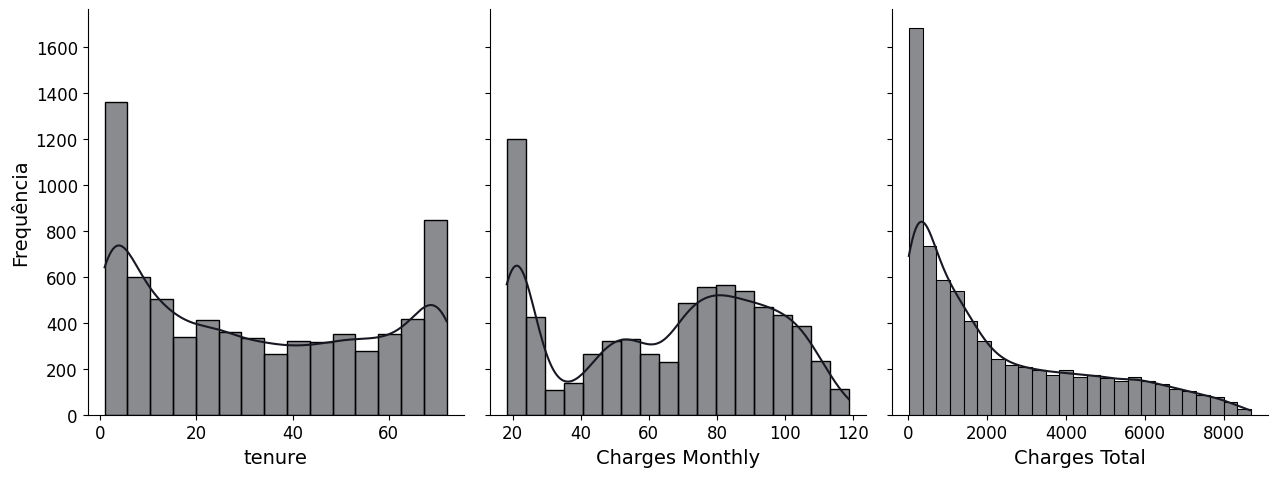

In [46]:
fig, axes = plt.subplots(1, len(col_num.columns), figsize=(13, 5), sharey = True)

for i, col in enumerate(col_num.columns):
    sns.histplot(df_sem_id[col], ax=axes[i], color=palette[0], kde=True)
    sns.despine(right=True, top=True)
    col_name = ' '.join(col.split('.')[1:])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

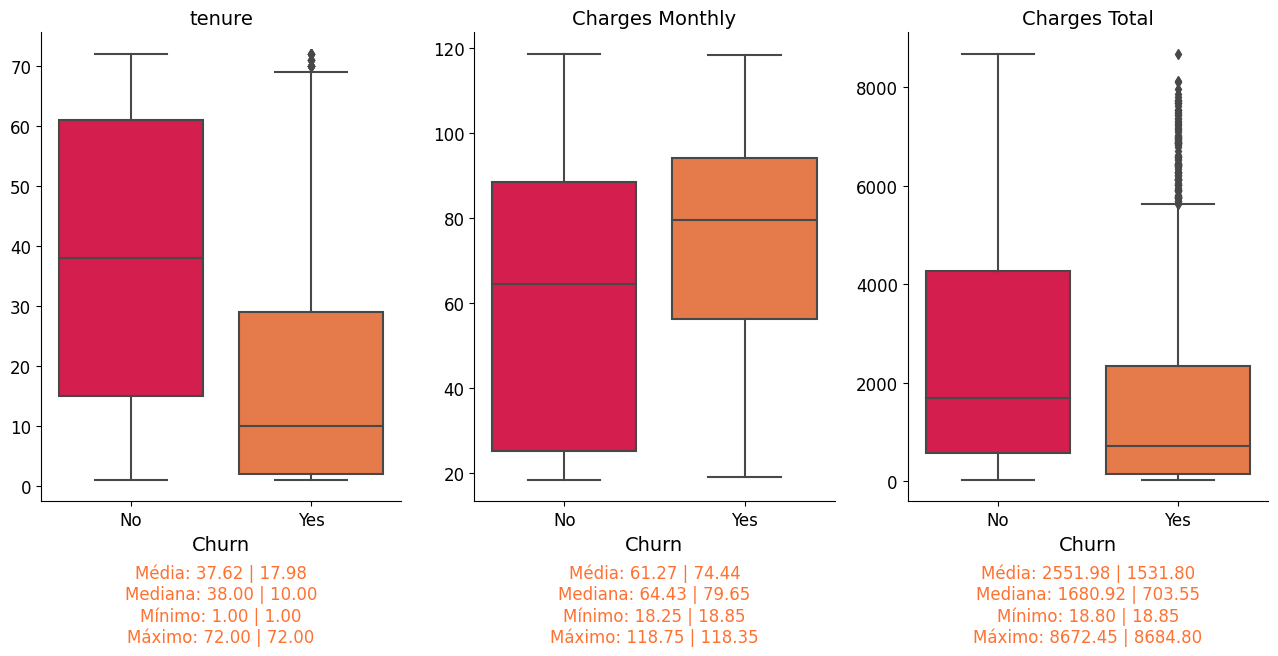

In [47]:
fig, axes = plt.subplots(1, len(col_num.columns), figsize=(13, 7))

for i, col in enumerate(col_num.columns):
    boxplot = sns.boxplot(x='Churn', y=col, data=df_sem_id, ax=axes[i], palette=palette[1:])
    for patch in boxplot.artists:
        patch.set_alpha(0.5)
    sns.despine(right=True, top=True)
    col_name = ' '.join(col.split('.')[1:])
    adicionar_estatisticas(axes[i], df_sem_id, col, -0.3, palette[2])
    axes[i].set_title(col_name)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

Conferindo as colunas númericas, é possível afirmar que:

* `Tenure`: Possui distribuição bicaudal
* `Monthly`: Tendência para a distribuição bicaudal
* `Total`: Distribuição assimétrica a esquerda, sinalizando uma alta concentração de contratos anuais baixos em relação a grandes contratos no mesmo período

Em relação aos boxplots a relação entre o Churn e o Charges total confirma o que foi apresentado pelo histograma, no qual a grande quantidade de churn se encontra em contratos com valores inferiores a 2000, com valores superiores a 6000 considerados acima do limite superior e em alguns casos podem ser tratados como outliers, portanto gera o comportamento de distribuição assimétrica para a direita.

Após a verificação da distribuição nas colunas categóricas e dos insights nas colunas numéricas, será necessário a preparação do dataset para a aplicação do algoritmo de aprendizado, portanto iremos remover todas as colunas categóricas e transformá-las em numéricas.

Para isso, inicialmente será realizado uma substituição simples de acordo com um mapeamento e posteriormente o algoritmo de get_dummies oferecido pelo pandas, de modo a simplificar essa transformação. Porém seria possível realizar o mapeamento de todas as colunas, conforme a primeira técnica citada.

In [48]:
for col in df_sem_id.select_dtypes(include=['object']).columns:
    print(f'{col}: {df_sem_id[col].unique()}')

Churn: ['No' 'Yes']
customer.gender: ['Female' 'Male']
customer.Partner: ['Yes' 'No']
customer.Dependents: ['Yes' 'No']
phone.PhoneService: ['Yes' 'No']
phone.MultipleLines: ['No' 'Yes' 'No phone service']
internet.InternetService: ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity: ['No' 'Yes' 'No internet service']
internet.OnlineBackup: ['Yes' 'No' 'No internet service']
internet.DeviceProtection: ['No' 'Yes' 'No internet service']
internet.TechSupport: ['Yes' 'No' 'No internet service']
internet.StreamingTV: ['Yes' 'No' 'No internet service']
internet.StreamingMovies: ['No' 'Yes' 'No internet service']
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaperlessBilling: ['Yes' 'No']
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [49]:
mapeamento = {
    'No':0,
    'Yes':1,
    'Male':0,
    'Female':1,
    'No phone service':0,
    'No internet service':0
}

In [50]:
colunas = ['Churn', 'customer.gender', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.PaperlessBilling']



In [51]:
df_sem_id[colunas] = df_sem_id[colunas].replace(mapeamento)
df_sem_id

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0,1,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30
1,0,0,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40
2,1,0,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85
3,1,0,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85
4,1,1,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,0,0,0,13,1,0,DSL,1,0,0,1,0,0,One year,0,Mailed check,55.15,742.90
7039,1,0,0,1,0,22,1,1,Fiber optic,0,0,0,0,0,1,Month-to-month,1,Electronic check,85.10,1873.70
7040,0,0,0,0,0,2,1,0,DSL,0,1,0,0,0,0,Month-to-month,1,Mailed check,50.30,92.75
7041,0,0,0,1,1,67,1,0,DSL,1,0,1,1,0,1,Two year,0,Mailed check,67.85,4627.65


In [52]:
for col in df_sem_id.columns:
    print(f'{col}: {df_sem_id[col].unique()}')

Churn: [0 1]
customer.gender: [1 0]
customer.SeniorCitizen: [0 1]
customer.Partner: [1 0]
customer.Dependents: [1 0]
customer.tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
phone.PhoneService: [1 0]
phone.MultipleLines: [0 1]
internet.InternetService: ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity: [0 1]
internet.OnlineBackup: [1 0]
internet.DeviceProtection: [0 1]
internet.TechSupport: [1 0]
internet.StreamingTV: [1 0]
internet.StreamingMovies: [0 1]
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaperlessBilling: [1 0]
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
account.Charges.Monthly: [65.6  59.9  73.9  ... 91.75 68.8  67.85]
account.Charges.Total: [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]


In [53]:
for col in df_sem_id.select_dtypes(include=['object']).columns:
    print(f'{col}: {df_sem_id[col].unique()}')

internet.InternetService: ['DSL' 'Fiber optic' 'No']
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [54]:
df_sem_id.drop(['account.Charges.Total'], axis=1, inplace=True)

In [55]:
for col in df_sem_id.columns:
    print(f'{col}: {df_sem_id[col].unique()}')

Churn: [0 1]
customer.gender: [1 0]
customer.SeniorCitizen: [0 1]
customer.Partner: [1 0]
customer.Dependents: [1 0]
customer.tenure: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
phone.PhoneService: [1 0]
phone.MultipleLines: [0 1]
internet.InternetService: ['DSL' 'Fiber optic' 'No']
internet.OnlineSecurity: [0 1]
internet.OnlineBackup: [1 0]
internet.DeviceProtection: [0 1]
internet.TechSupport: [1 0]
internet.StreamingTV: [1 0]
internet.StreamingMovies: [0 1]
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaperlessBilling: [1 0]
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
account.Charges.Monthly: [65.6  59.9  73.9  ... 91.75 68.8  67.85]


In [56]:
df_sem_id_dummies = df_sem_id.copy()
df_sem_id_one_hot = df_sem_id.copy()

# Encoding

## Tipos de encoding:

* `Label Encoding`: Renomea as classes com valores numéricos de 1 a n, sendo n o número de classes. Pode eexistir hierarquias entre as classes.
   
* `One-Hot Encoding`: Transforma as variáveis em n colunas binárias, sendo n o número de classes. Todas as classes são analisadas de form igual, quando tiver a ocorrência dela a coluna terá o valor 1 e quando não o valor 0, isso acontece para as demais colunas criadas.
 
 Vamos optar pelo método que transforma as variáveis em colunas binárias. Para isso é possível utilizar duas formas:
   
* `get_dummies`: Cada variável é convertida como 0/1 conforme o número de variáveis diferentes. Cada coluna de saida recebe o nome de um valor, se a entrada for um DataFrame, o nome da variável original será inserida em conjunto.
   
* `OneHotEncoder`: A entrada deve ser uima matriz de números inteiros ou strings, denotando os valores categóricos, assim os valores serão codificados usando um esquema one-hot, o qual cria uma coluna binária para cada categoria e retorna uma matriz.
   
Entre os dois tipos, o que se é comumente recomendado é que a codificação get_dummies seja utilizada visando a análise de dados, uma vez que se for necessário a utilização de novos dados que possuem uma característica que não estava presente na construção do modelo, ela não será entendida pelo modelo treinado. Diferente do OneHotEncoder, portanto este último é o recomendado para a criação de modelos de aprendizado de máquina.

Portanto será utilizado o encoding One-Hot Encoding e o método OneHotEncoder

A critério de estudos foi gerado um DataFrame utilizando ambos os modelos, porém para a criação do modelo de previsão, apenas o OneHotEncoder foi considerado

### Get_dummies

In [57]:
df_dummies = pd.get_dummies(df_sem_id_dummies).copy()
df_dummies.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,...,internet.InternetService_DSL,internet.InternetService_Fiber optic,internet.InternetService_No,account.Contract_Month-to-month,account.Contract_One year,account.Contract_Two year,account.PaymentMethod_Bank transfer (automatic),account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,1,0,1,1,9,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,9,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,4,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,1,0,1,1,0,13,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,1,1,1,1,0,3,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [58]:
df_dummies.columns

Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity',
       'internet.OnlineBackup', 'internet.DeviceProtection',
       'internet.TechSupport', 'internet.StreamingTV',
       'internet.StreamingMovies', 'account.PaperlessBilling',
       'account.Charges.Monthly', 'internet.InternetService_DSL',
       'internet.InternetService_Fiber optic', 'internet.InternetService_No',
       'account.Contract_Month-to-month', 'account.Contract_One year',
       'account.Contract_Two year',
       'account.PaymentMethod_Bank transfer (automatic)',
       'account.PaymentMethod_Credit card (automatic)',
       'account.PaymentMethod_Electronic check',
       'account.PaymentMethod_Mailed check'],
      dtype='object')

In [59]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Churn                                            7043 non-null   int64  
 1   customer.gender                                  7043 non-null   int64  
 2   customer.SeniorCitizen                           7043 non-null   int64  
 3   customer.Partner                                 7043 non-null   int64  
 4   customer.Dependents                              7043 non-null   int64  
 5   customer.tenure                                  7043 non-null   int64  
 6   phone.PhoneService                               7043 non-null   int64  
 7   phone.MultipleLines                              7043 non-null   int64  
 8   internet.OnlineSecurity                          7043 non-null   int64  
 9   internet.OnlineBackup         

In [60]:
#col_num = ['Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'account.PaperlessBilling', 'account.Charges.Monthly']

col_num = df_sem_id_dummies.select_dtypes(exclude=['object']).columns
col_num

Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity',
       'internet.OnlineBackup', 'internet.DeviceProtection',
       'internet.TechSupport', 'internet.StreamingTV',
       'internet.StreamingMovies', 'account.PaperlessBilling',
       'account.Charges.Monthly'],
      dtype='object')

In [61]:
df_dummies[col_num].corr().round(3)

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,account.Charges.Monthly
Churn,1.000,0.009,0.151,-0.150,-0.164,-0.354,0.012,0.040,-0.171,-0.082,-0.066,-0.165,0.063,0.061,0.192,0.193
customer.gender,0.009,1.000,0.002,0.002,-0.011,-0.005,0.006,0.008,0.017,0.014,0.002,0.009,0.008,0.010,0.012,0.015
customer.SeniorCitizen,0.151,0.002,1.000,0.016,-0.211,0.016,0.009,0.143,-0.039,0.067,0.059,-0.061,0.105,0.120,0.157,0.220
customer.Partner,-0.150,0.002,0.016,1.000,0.453,0.381,0.018,0.142,0.143,0.141,0.154,0.120,0.125,0.117,-0.015,0.097
customer.Dependents,-0.164,-0.011,-0.211,0.453,1.000,0.162,-0.002,-0.025,0.081,0.024,0.014,0.063,-0.017,-0.040,-0.111,-0.114
customer.tenure,-0.354,-0.005,0.016,0.381,0.162,1.000,0.008,0.332,0.328,0.361,0.361,0.325,0.280,0.286,0.005,0.247
phone.PhoneService,0.012,0.006,0.009,0.018,-0.002,0.008,1.000,0.280,-0.093,-0.052,-0.071,-0.096,-0.023,-0.033,0.017,0.247
phone.MultipleLines,0.040,0.008,0.143,0.142,-0.025,0.332,0.280,1.000,0.098,0.202,0.201,0.101,0.257,0.259,0.164,0.490
internet.OnlineSecurity,-0.171,0.017,-0.039,0.143,0.081,0.328,-0.093,0.098,1.000,0.284,0.275,0.355,0.176,0.187,-0.004,0.297
internet.OnlineBackup,-0.082,0.014,0.067,0.141,0.024,0.361,-0.052,0.202,0.284,1.000,0.304,0.294,0.282,0.275,0.127,0.442


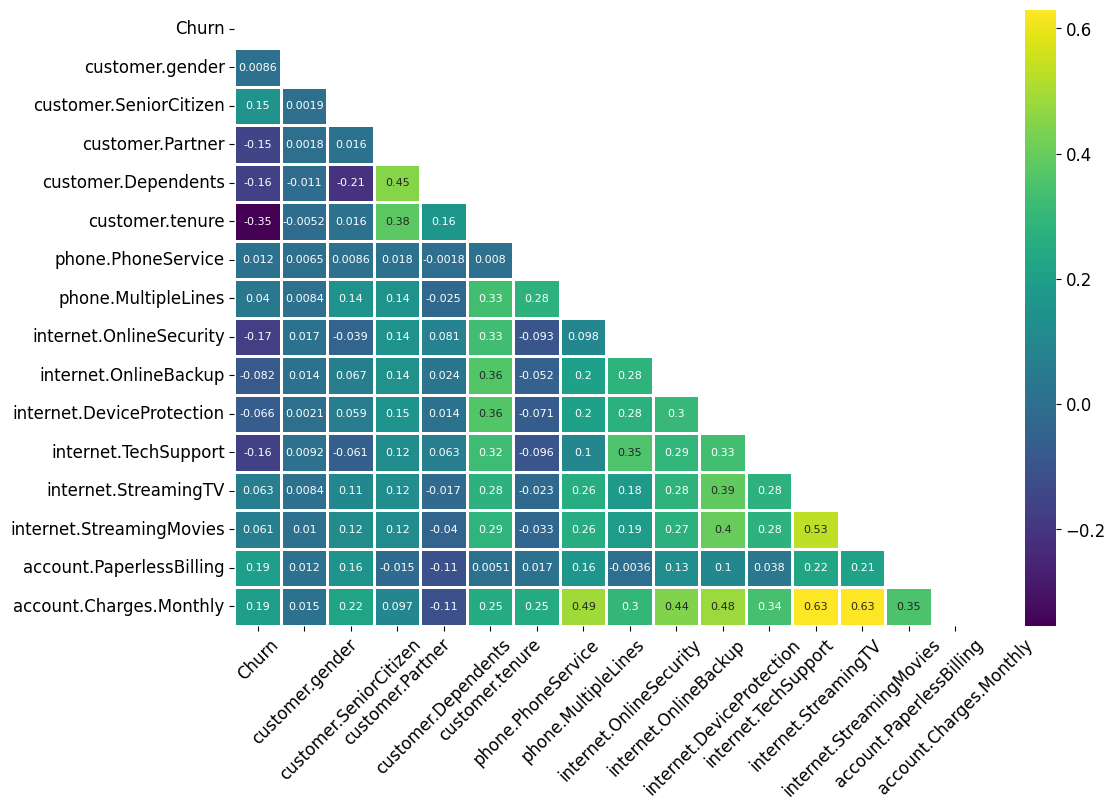

In [62]:
df = df_dummies[col_num].corr()    

mask = np.triu(np.ones_like(df, dtype=bool))
plt.figure(figsize=(12,8))

ax = sns.heatmap(df,
                 xticklabels=df.columns.values,
                 yticklabels=df.columns.values,
                 annot=True,
                 annot_kws={'size':8},
                 linewidth=.8,
                 cmap='viridis',
                 mask=mask)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [63]:
df_sem_id_dummies.loc[df_sem_id_dummies['Churn']==1]['customer.gender'].count()/df_sem_id_dummies.loc[df_sem_id_dummies['Churn']]['customer.gender'].count()


0.2653698707936959

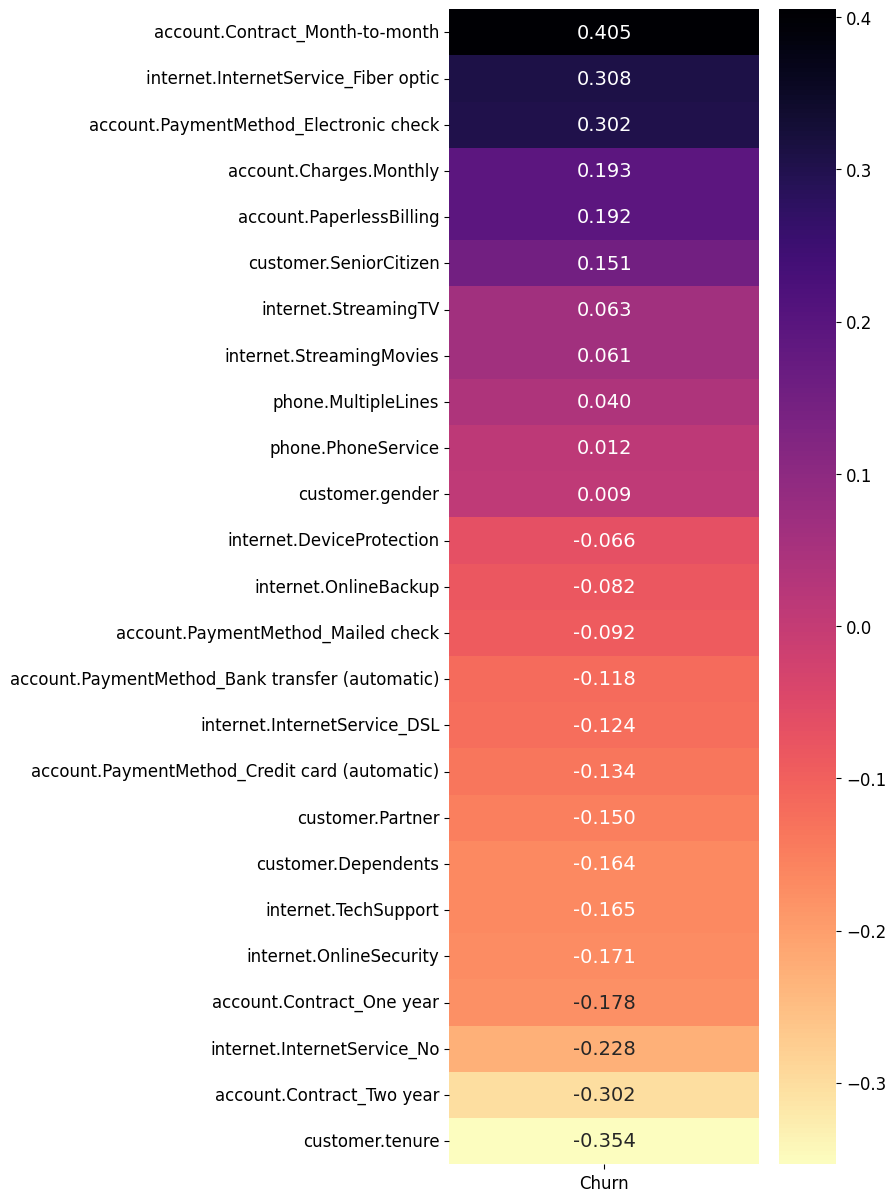

In [64]:
corr = df_dummies.corrwith(df_dummies['Churn']).sort_values(ascending=False).to_frame().iloc[1:,:]
corr.columns = ['Churn']

plt.figure(figsize=(5, 15))
sns.heatmap(corr, annot=True, cmap='magma_r', fmt= '.3f')
plt.show()

Observando a tabela de valores e principalmente a escala de correlação é possível identificar que o contrato com duração mês a mês, serviço de internet com fibra ótica e método de pagamento eletrônico são os que possuem maior correlação com o número de cancelamentos, ou seja, Churn.

### One-hot encoding

In [65]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [66]:
for col in df_sem_id.select_dtypes(include=['object']).columns:
    print(f'{col}: {df_sem_id[col].unique()}')

internet.InternetService: ['DSL' 'Fiber optic' 'No']
account.Contract: ['One year' 'Month-to-month' 'Two year']
account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


In [67]:
cat_col = ['internet.InternetService', 'account.Contract', 'account.PaymentMethod']

one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), cat_col), remainder='passthrough')

dados_ohe = one_hot_enc.fit_transform(df_sem_id_one_hot)
dados_ohe = pd.DataFrame(dados_ohe, columns=one_hot_enc.get_feature_names_out())
dados_ohe

,onehotencoder__internet.InternetService_DSL,onehotencoder__internet.InternetService_Fiber optic,onehotencoder__internet.InternetService_No,onehotencoder__account.Contract_Month-to-month,onehotencoder__account.Contract_One year,onehotencoder__account.Contract_Two year,onehotencoder__account.PaymentMethod_Bank transfer (automatic),onehotencoder__account.PaymentMethod_Credit card (automatic),onehotencoder__account.PaymentMethod_Electronic check,onehotencoder__account.PaymentMethod_Mailed check,...,remainder__phone.PhoneService,remainder__phone.MultipleLines,remainder__internet.OnlineSecurity,remainder__internet.OnlineBackup,remainder__internet.DeviceProtection,remainder__internet.TechSupport,remainder__internet.StreamingTV,remainder__internet.StreamingMovies,remainder__account.PaperlessBilling,remainder__account.Charges.Monthly
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,65.60
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59.90
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,73.90
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,98.00
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,83.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,55.15
7039,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,85.10
7040,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50.30
7041,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,67.85


In [68]:
dados_ohe.columns

Index(['onehotencoder__internet.InternetService_DSL',
       'onehotencoder__internet.InternetService_Fiber optic',
       'onehotencoder__internet.InternetService_No',
       'onehotencoder__account.Contract_Month-to-month',
       'onehotencoder__account.Contract_One year',
       'onehotencoder__account.Contract_Two year',
       'onehotencoder__account.PaymentMethod_Bank transfer (automatic)',
       'onehotencoder__account.PaymentMethod_Credit card (automatic)',
       'onehotencoder__account.PaymentMethod_Electronic check',
       'onehotencoder__account.PaymentMethod_Mailed check', 'remainder__Churn',
       'remainder__customer.gender', 'remainder__customer.SeniorCitizen',
       'remainder__customer.Partner', 'remainder__customer.Dependents',
       'remainder__customer.tenure', 'remainder__phone.PhoneService',
       'remainder__phone.MultipleLines', 'remainder__internet.OnlineSecurity',
       'remainder__internet.OnlineBackup',
       'remainder__internet.DeviceProtection',

In [69]:
dados_ohe = dados_ohe.rename(columns={'remainder__Churn': 'Churn'})

In [70]:
dados_ohe.columns

Index(['onehotencoder__internet.InternetService_DSL',
       'onehotencoder__internet.InternetService_Fiber optic',
       'onehotencoder__internet.InternetService_No',
       'onehotencoder__account.Contract_Month-to-month',
       'onehotencoder__account.Contract_One year',
       'onehotencoder__account.Contract_Two year',
       'onehotencoder__account.PaymentMethod_Bank transfer (automatic)',
       'onehotencoder__account.PaymentMethod_Credit card (automatic)',
       'onehotencoder__account.PaymentMethod_Electronic check',
       'onehotencoder__account.PaymentMethod_Mailed check', 'Churn',
       'remainder__customer.gender', 'remainder__customer.SeniorCitizen',
       'remainder__customer.Partner', 'remainder__customer.Dependents',
       'remainder__customer.tenure', 'remainder__phone.PhoneService',
       'remainder__phone.MultipleLines', 'remainder__internet.OnlineSecurity',
       'remainder__internet.OnlineBackup',
       'remainder__internet.DeviceProtection',
       're

# Churn Desbalanceado

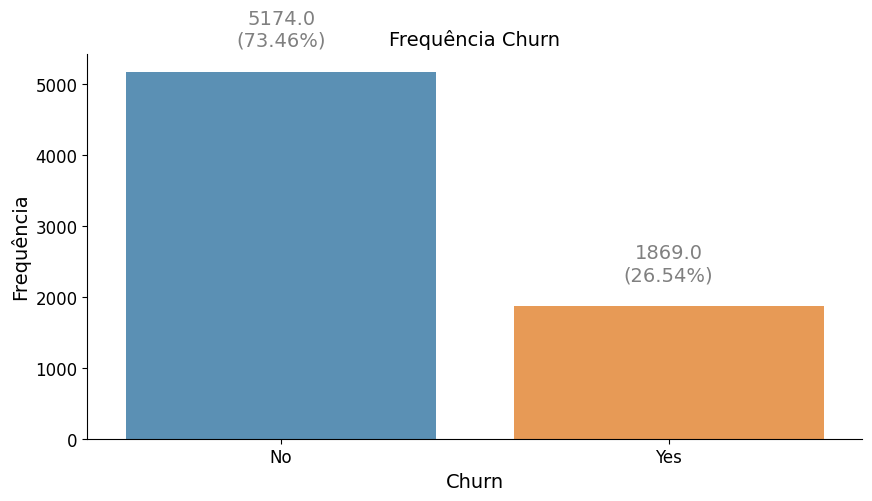

In [71]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=dados_ohe, x='Churn', alpha=.8)
#sns.color_palette("Paired", as_cmap=True)
sns.color_palette(palette=palette, as_cmap=True)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.title('Frequência Churn')
ax.set(xticklabels=["No", "Yes"]);
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{y}\n({y/len(df_sem_id)*100:.2f}%)\n', (x, y),
                ha='center', va='bottom', color='gray')
plt.show()

Observando as frequências de Churn apresentadas no DataFrame de treino, notasse uma predominância consideravél de respostas Negativas ao Churn, desse modo, caso o algoritmo de aprendizado seja treinado, irá possuir um comportamento tendêncioso para indicar respostas Negativas ao Churn. Portanto é essencial realizar o balanceamento dos dados antes de treinar o algoritmo.

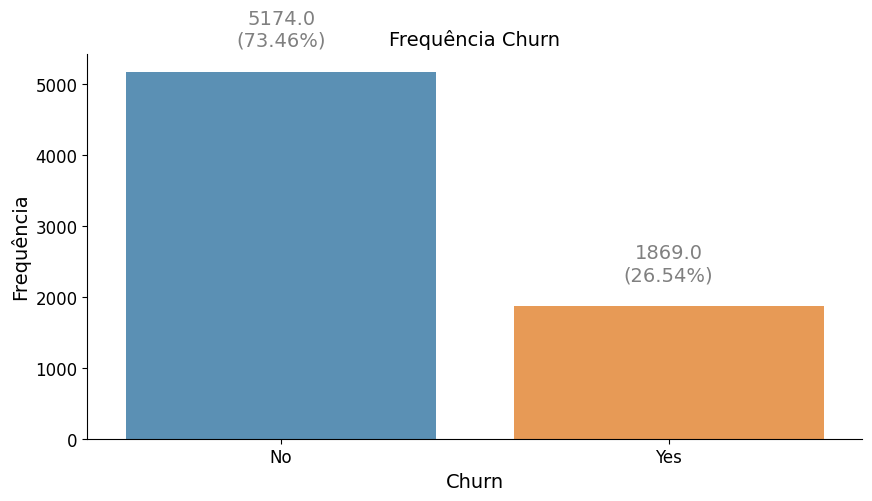

In [80]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=df_dummies, x='Churn', alpha=.8)
#sns.color_palette("Paired", as_cmap=True)
sns.color_palette(palette=palette, as_cmap=True)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.title('Frequência Churn')
ax.set(xticklabels=["No", "Yes"]);
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{y}\n({y/len(df_sem_id)*100:.2f}%)\n', (x, y),
                ha='center', va='bottom', color='gray')
plt.show()

Para realizar o balanceamento dos dados desbalanceados existem diferentes técnicas, sendo as mais comuns:

* `Undersampling`: Técnica na qual é realizada uma igualdade entre as respostas disponíveis, então, para o caso a quantidade de respostas negativas serão cortadas de maneira aleatória até possuir a mesma quantidade de respostas positivas, para o problema 1869. A desvantagem desse método é a considerável perda de informações em problemas, nos quais as respostas estão bem desbalanceadas, podendo assim ocultar algum padrão de ser detectado pelo algoritmo.

* `Oversampling`: Oposto ao método anterior, tem como objetivo inserir dados naquele que está desbalanceado, contudo essa criação de novas respostas pode acabar gerando muitos dados duplicados, forçando correlações e outros comportamentos ao DataFrame. Para evitar isso será utilizado o SMOTE - Synthetic Minority Over-sampling Technique da biblioteca do Imblearn, criando respostas artificiais aleatóriamente presente no dado que se encontra em minoria.

Um detalhe muito importante é que SMOTE deve ser aplicado apenas aos dados de treinamento, e não aos dados de teste. Isso porque, ao oversampling antes de dividir os dados, as mesmas observações podem acabar tanto no conjunto de treinamento quanto no conjunto de teste. Isso faria com que seu modelo tivesse uma precisão inflada quando testado, porque o modelo já viu esses exemplos durante o treinamento.


In [81]:
seed=42
smote = SMOTE(random_state=seed)

In [82]:
x = dados_ohe.drop(['Churn'], axis=1)
y = dados_ohe['Churn']

In [83]:
x_resampled, y_resampled = smote.fit_resample(x, y)
df_balanceado = pd.concat([x_resampled, y_resampled], axis=1)
df_balanceado

,onehotencoder__internet.InternetService_DSL,onehotencoder__internet.InternetService_Fiber optic,onehotencoder__internet.InternetService_No,onehotencoder__account.Contract_Month-to-month,onehotencoder__account.Contract_One year,onehotencoder__account.Contract_Two year,onehotencoder__account.PaymentMethod_Bank transfer (automatic),onehotencoder__account.PaymentMethod_Credit card (automatic),onehotencoder__account.PaymentMethod_Electronic check,onehotencoder__account.PaymentMethod_Mailed check,...,remainder__phone.MultipleLines,remainder__internet.OnlineSecurity,remainder__internet.OnlineBackup,remainder__internet.DeviceProtection,remainder__internet.TechSupport,remainder__internet.StreamingTV,remainder__internet.StreamingMovies,remainder__account.PaperlessBilling,remainder__account.Charges.Monthly,Churn
0,1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,65.600000,0.0
1,1.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,59.900000,0.0
2,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,73.900000,1.0
3,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,98.000000,1.0
4,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,83.900000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,85.235939,1.0
10344,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.767279,0.000000,0.0,0.767279,0.000000,1.000000,0.232721,1.000000,92.244007,1.0
10345,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,20.276666,1.0
10346,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.000000,0.516309,0.0,0.000000,0.000000,0.483691,0.000000,0.483691,83.778519,1.0


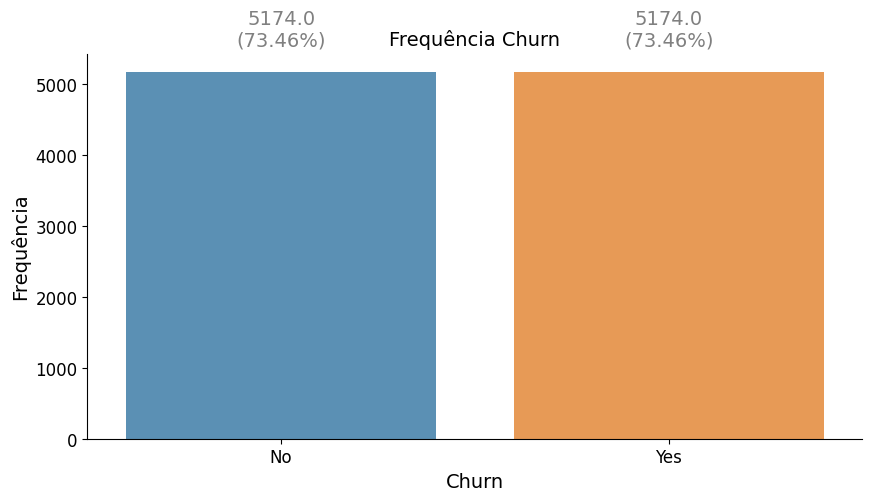

In [84]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=df_balanceado, x='Churn', alpha=.8)
#sns.color_palette("Paired", as_cmap=True)
sns.color_palette(palette=palette, as_cmap=True)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.title('Frequência Churn')
ax.set(xticklabels=["No", "Yes"]);
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{y}\n({y/len(df_sem_id)*100:.2f}%)\n', (x, y),
                ha='center', va='bottom', color='gray')
plt.show()

Assim, após aplicarmos a técnica do SMOTE em conjunto com o Oversampling, obtemos um conjunto com respostas equilibradas adequadas para o treinamento do algoritmo de aprendizado.


# Semana 2

Para realizar o treinamento precisamos separar em 2 variáveis, sendo uma delas apenas com a variável target e a outra com as restantes.

Além disso, para avaliar os algoritmos selecionados, algumas métricas são utilizadas, sendo elas:

* `Acurácia`: Mede a proporção de previsões corretas feitas pelo modelo. No entanto, a acurácia pode ser uma métrica enganosa se a distribuição das classes for desbalanceada.

* `Precision`: Mede a proporção de previsões de churn que são realmente churn. Um valor alto de precisão indica que, quando o modelo prevê churn, é provável que seja um churn verdadeiro.

* `Recall`: Mede a proporção de churns reais que o modelo é capaz de capturar através de suas previsões. Um valor alto de recall indica que o modelo é bom em detectar churns.

* `F1-Score`: É a média harmônica entre precisão e recall. É uma métrica que busca balancear precisão e recall, sendo útil quando ambas são importantes para o problema

No contexto de previsão de churn, geralmente queremos identificar o máximo de clientes que darão churn (alto recall), mas também queremos estar certos nas nossas previsões para não gastar recursos desnecessários tentando reter clientes que não dariam churn (alta precisão). Portanto, o F1-Score pode ser uma boa métrica a ser considerada, pois balanceia estas duas métricas.

In [85]:
x = df_balanceado.drop(['Churn'], axis=1)
y = df_balanceado['Churn']

In [86]:
def metricas(y_test, y_pred):
    print(f'Acurácia: ', metrics.accuracy_score(y_test, y_pred))
    print(f'Precisão: ', metrics.precision_score(y_test, y_pred))
    print(f'Recall: ', metrics.recall_score(y_test, y_pred))
    print(f'F1: ', metrics.f1_score(y_test, y_pred))
    
def conf_matrix(cm, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

In [87]:
seed = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=seed)

In [88]:
model = DecisionTreeClassifier(max_depth=5, random_state=seed)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
metricas(y_test, y_pred)

Acurácia:  0.8013142636258214
Precisão:  0.8041733547351525
Recall:  0.7877358490566038
F1:  0.795869737887212


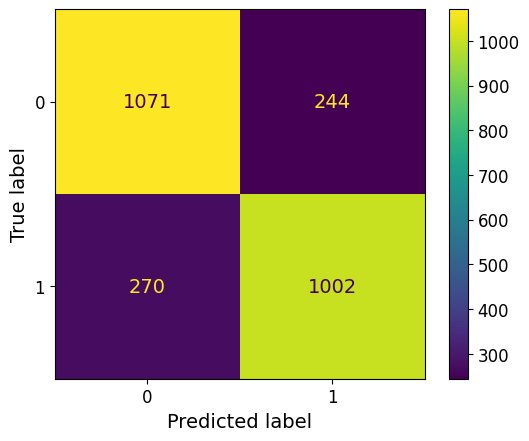

In [89]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

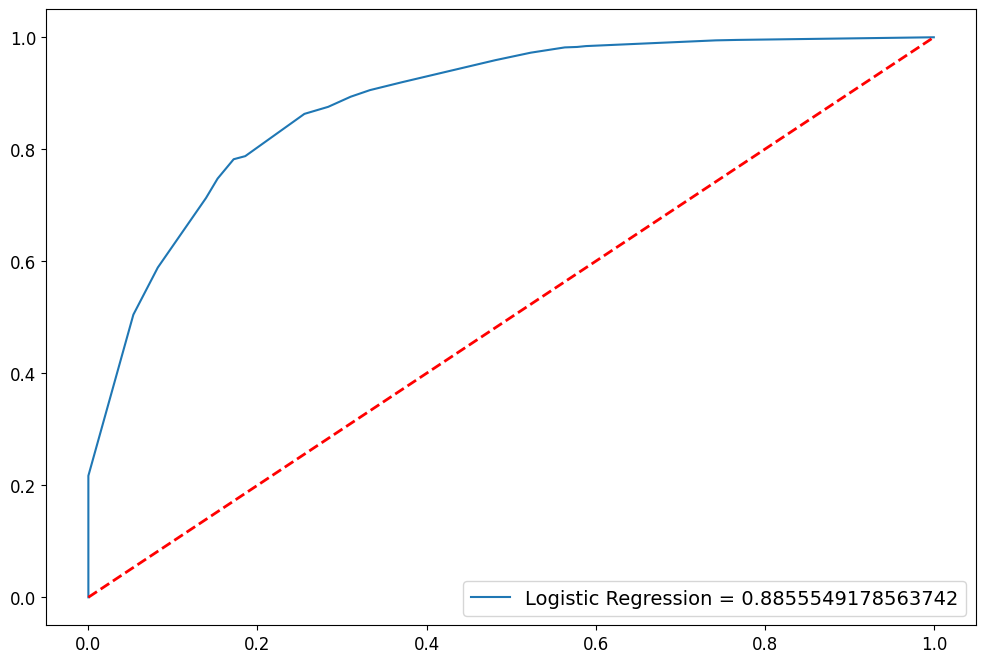

In [90]:
y_pred_prob = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'Logistic Regression = ' +str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw=2, linestyle= '--')
plt.legend(loc=4)

Testando as métricas, a matriz de confusão e a curva ROC utilizando o método de Árvore de Decisão, é possível identificar os medidores de desempenho, a quantidade de valores previstos x verdadeiros e a capacidade de determinação da ocorrência de churn.

Criando uma função e um dicionário é possível realizar o mesmo teste para diferentes modelos diferentes e utilizar os indices obtidos para classificar qual deles possui um melhor desempenho para o DataFrame utilizado.

In [91]:
def executar_classificador(classificador, x_train, x_test, y_train):
    classificador.fit(x_train, y_train)
    y_pred = classificador.predict(x_test)
    return y_pred


In [92]:
classifiers = {
    'Regressão Logística': LogisticRegression(random_state=seed, max_iter=1000),
    'K-Vizinhos Mais Próximos (KNN)': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=seed),
    'Support Vector Machine': SVC(random_state=seed),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=seed),
    'Floresta Randômica': RandomForestClassifier(random_state=seed),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=seed)
}

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Não Churn', 'Churn']

In [119]:
modelos = ['LogisticRegression', 'KNeighborsClassifier (KNM)', 'GradientBoostingClassifier', 'Support Vector Machine', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier']
acc_treino = []
acc_teste = []
prec = []
rec = []
f1 = []


for i in classifiers:
    model = classifiers[i]
    y_pred = executar_classificador(model, x_train, x_test, y_train)
    print(f'Modelo: {classifiers[i]}')
    #modelos.append(classifiers[i])
    #acc_treino.append(metrics.accuracy_score(y_train, y_pred))
    acc_teste.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    rec.append(metrics.recall_score(y_test, y_pred))
    f1.append(metrics.f1_score(y_test, y_pred))
    metricas(y_test, y_pred)
    #conf_matrix(cm, y_test, y_pred)
    #plot_matriz_confusao(y_test, y_pred, group_names=labels, categories=categories, figsize=(8, 6), title=classifiers[i])
    print('-'*30)
    

Modelo: LogisticRegression(max_iter=1000, random_state=42)
Acurácia:  0.761886354851179
Precisão:  0.742245199409158
Recall:  0.7900943396226415
F1:  0.7654226961157654
------------------------------
Modelo: KNeighborsClassifier()
Acurácia:  0.7862388867413993
Precisão:  0.725958516656191
Recall:  0.9080188679245284
F1:  0.8068459657701712
------------------------------
Modelo: GradientBoostingClassifier(random_state=42)
Acurácia:  0.860456126787785
Precisão:  0.8617950754567116
Recall:  0.8529874213836478
F1:  0.857368629000395
------------------------------
Modelo: SVC(random_state=42)
Acurácia:  0.7402396598376498
Precisão:  0.7225519287833828
Recall:  0.7657232704402516
F1:  0.7435114503816794
------------------------------
Modelo: DecisionTreeClassifier(random_state=42)
Acurácia:  0.8020873598763046
Precisão:  0.797339593114241
Recall:  0.8011006289308176
F1:  0.7992156862745098
------------------------------
Modelo: RandomForestClassifier(random_state=42)
Acurácia:  0.86122922303

In [120]:
#metrica= {'Modelo', 'Acurácia Treino', 'Acurácia Teste', 'Precisão', 'Recall', 'F1-Score'}
tabela = pd.DataFrame({'Modelo': modelos, 'Acurácia Teste': acc_teste, 'Precisão': prec, 'Recall': rec, 'F1-Score': f1})
tabela.sort_values(by='Modelo', ascending=False).reset_index(drop=True)

,Modelo,Acurácia Teste,Precisão,Recall,F1-Score
0,Support Vector Machine,0.740240,0.722552,0.765723,0.743511
1,RandomForestClassifier,0.861229,0.883936,0.826258,0.854124
2,LogisticRegression,0.761886,0.742245,0.790094,0.765423
3,KNeighborsClassifier (KNM),0.786239,0.725959,0.908019,0.806846
4,GradientBoostingClassifier,0.860456,0.861795,0.852987,0.857369
5,DecisionTreeClassifier,0.802087,0.797340,0.801101,0.799216
6,AdaBoostClassifier,0.844608,0.843060,0.840409,0.841732


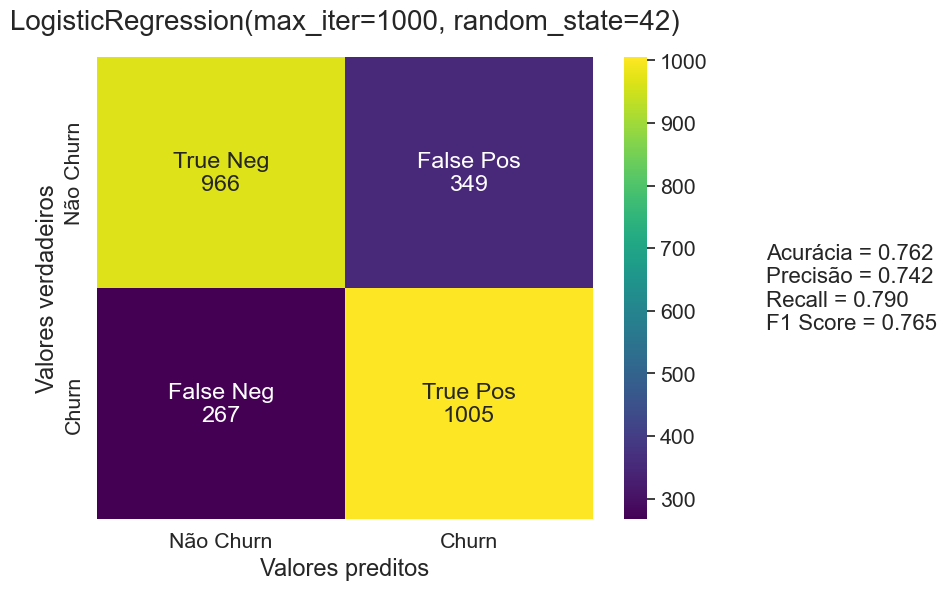

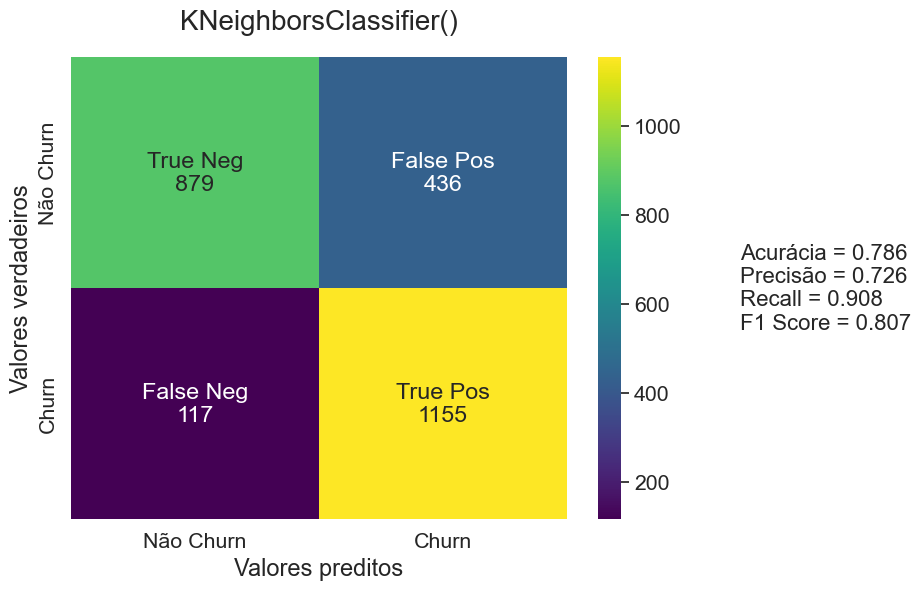

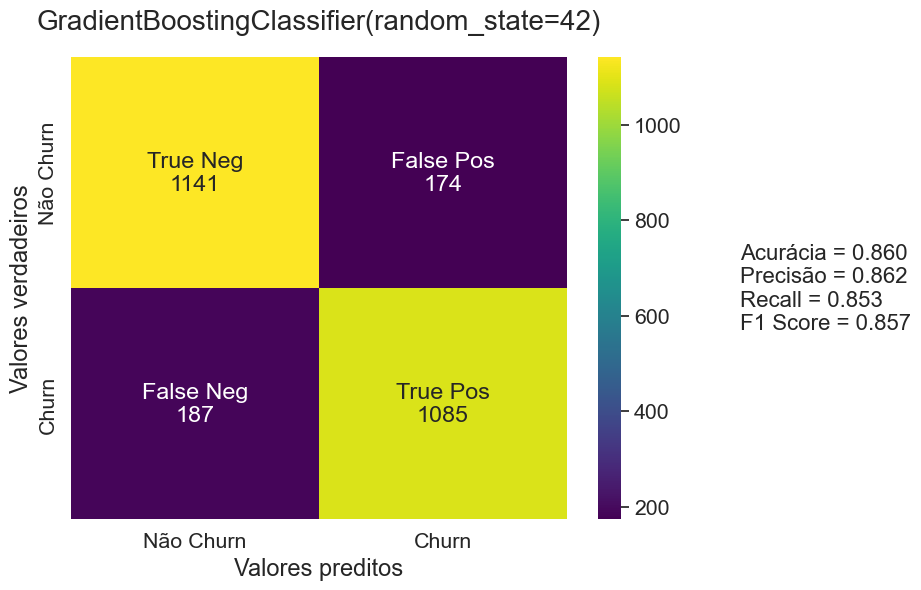

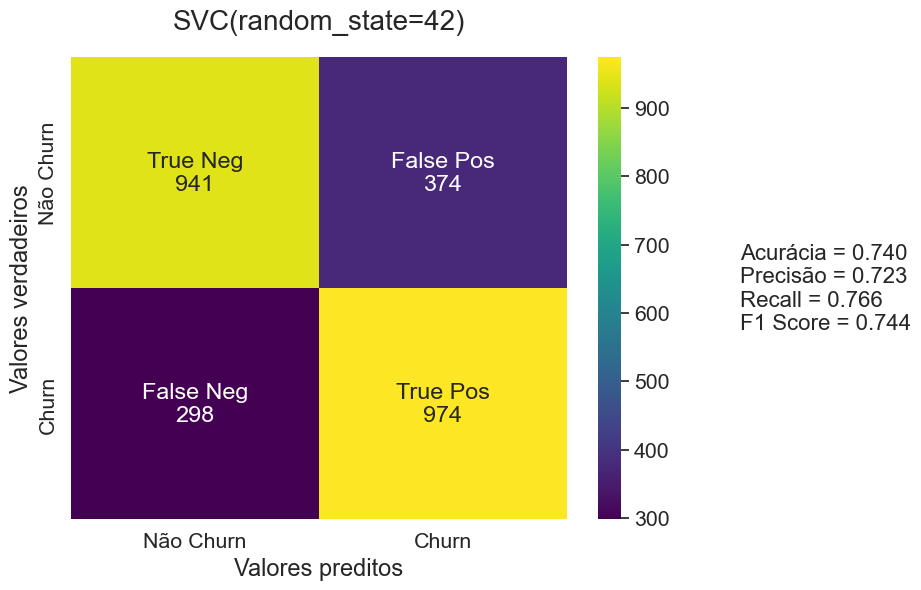

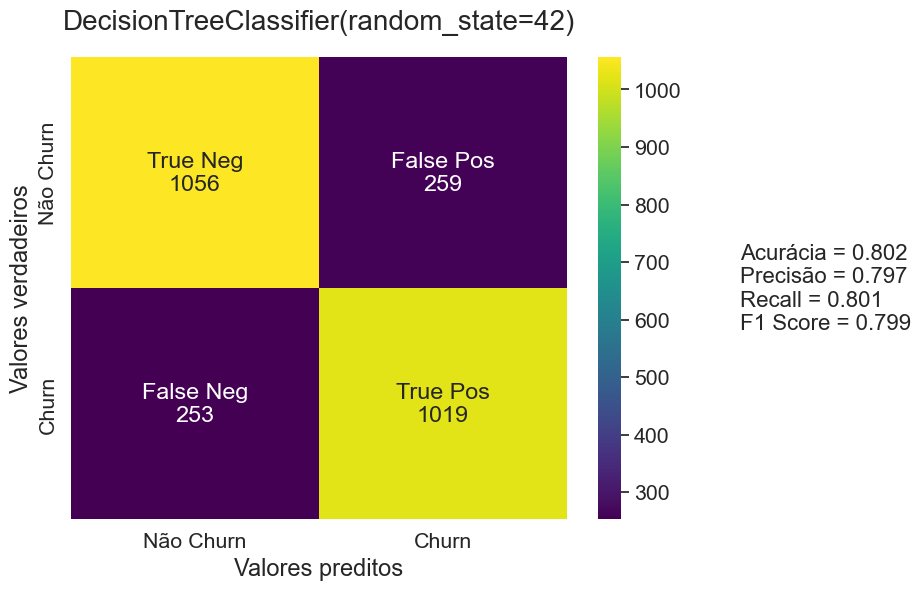

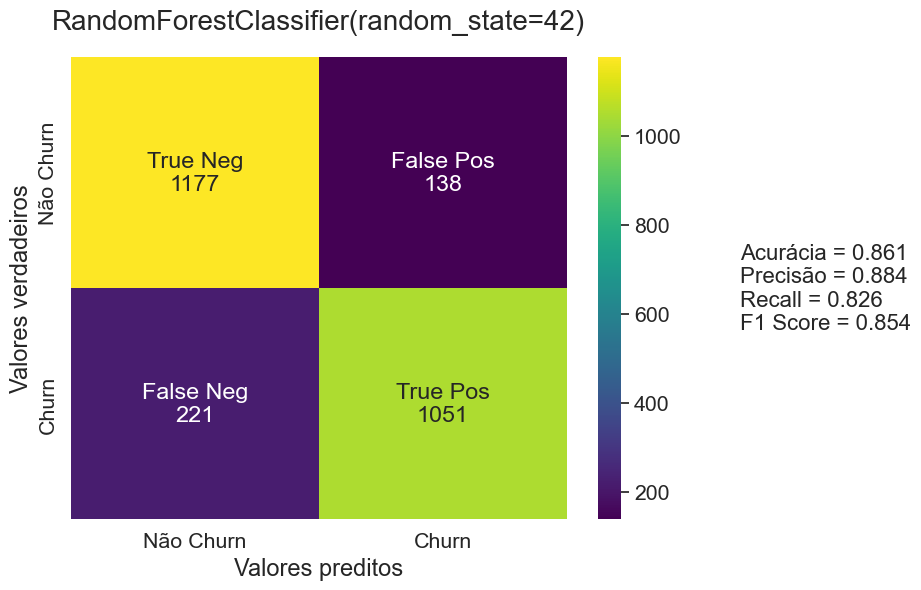

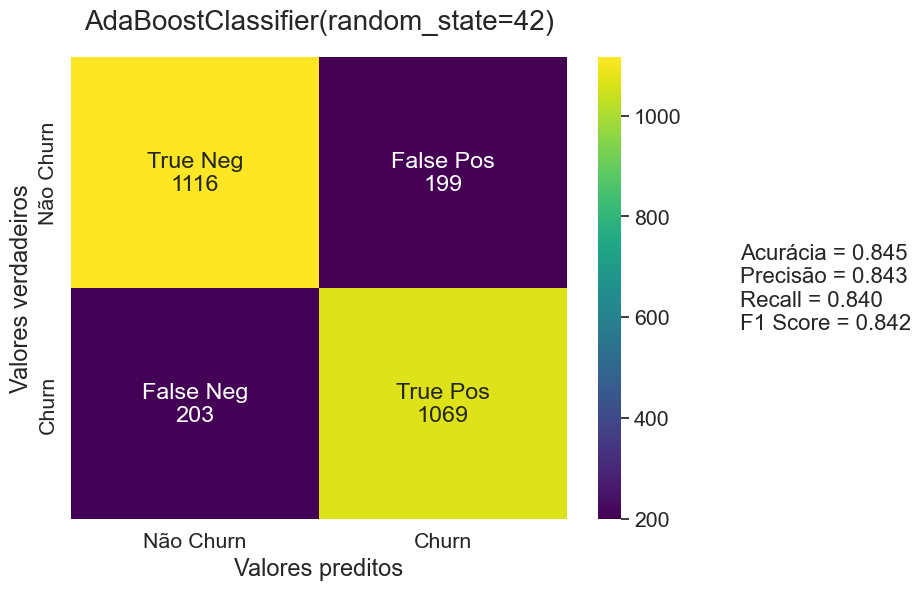

In [99]:
for i in classifiers:
    model = classifiers[i]
    y_pred = executar_classificador(model, x_train, x_test, y_train)
    #print(f'Modelo: {classifiers[i]}')
    #metricas(y_test, y_pred)
    #conf_matrix(cm, y_test, y_pred)
    plot_matriz_confusao(y_test, y_pred, group_names=labels, categories=categories, figsize=(8, 6), title=classifiers[i])
    #print('-'*30)

In [121]:
#metrica= {'Modelo', 'Acurácia Treino', 'Acurácia Teste', 'Precisão', 'Recall', 'F1-Score'}
tabela = pd.DataFrame({'Modelo': modelos, 'Acurácia Teste': acc_teste, 'Precisão': prec, 'Recall': rec, 'F1-Score': f1})
tabela.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

,Modelo,Acurácia Teste,Precisão,Recall,F1-Score
0,GradientBoostingClassifier,0.860456,0.861795,0.852987,0.857369
1,RandomForestClassifier,0.861229,0.883936,0.826258,0.854124
2,AdaBoostClassifier,0.844608,0.843060,0.840409,0.841732
3,KNeighborsClassifier (KNM),0.786239,0.725959,0.908019,0.806846
4,DecisionTreeClassifier,0.802087,0.797340,0.801101,0.799216
5,LogisticRegression,0.761886,0.742245,0.790094,0.765423
6,Support Vector Machine,0.740240,0.722552,0.765723,0.743511


Sabendo que o objetivo é de maximizar o F1-Score e comparando todos os 6 modelos verificados, conclue-se que o GradientBoosterClassifier é o mais indicado, seguido de perto pelo RandomForestClassifier.

Com o modelo definido, iremos utilizar a biblioteca GridSearchCV para obtermos uma otimização, desse modo, os hiperparâmetros que serão passados ao GridSearchCV serão:

* `n_estimators`: número de árvores de decisão;
* `criterion`: critério de decisão;
* `max_depth`: profundidade máxima da árvore de decisão;
* `min_samples_split`: número mínimo de amostras necessárias para que uma divisão seja feita;
* `min_samples_leaf`: número mínimo de amostras necessárias para que uma folha seja formada;



In [131]:
n_estimators = np.arange(100, 200, step=20)
#criterion = ['gini', 'entropy']
criterion = ['friedman_mse', 'squared_error']
max_depth = list(np.arange(2, 10, step=2))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [2, 4]
bootstrap = [True, False]


parameters = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    #'bootstrap': bootstrap,
}

In [132]:
clf = GridSearchCV(GradientBoostingClassifier(random_state=seed), parameters, cv=3, n_jobs=-1, scoring='f1')
clf.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [2, 4],
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([100, 120, 140, 160, 180])},
             scoring='f1')

In [133]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
40,1.735105,0.014682,0.011473,0.000711,friedman_mse,4,2,2,100,"{'criterion': 'friedman_mse', 'max_depth': 4, ...",0.858671,0.863566,0.860348,0.860862,0.002031,1
45,1.948075,0.094780,0.011807,0.000626,friedman_mse,4,2,4,100,"{'criterion': 'friedman_mse', 'max_depth': 4, ...",0.858671,0.863566,0.860348,0.860862,0.002031,1
200,2.201495,0.180508,0.012173,0.000855,squared_error,4,2,2,100,"{'criterion': 'squared_error', 'max_depth': 4,...",0.858671,0.863566,0.860348,0.860862,0.002031,1
205,2.191064,0.109105,0.013440,0.001234,squared_error,4,2,4,100,"{'criterion': 'squared_error', 'max_depth': 4,...",0.858671,0.863566,0.860348,0.860862,0.002031,1
55,1.996301,0.161558,0.011636,0.000940,friedman_mse,4,2,8,100,"{'criterion': 'friedman_mse', 'max_depth': 4, ...",0.859004,0.863337,0.859466,0.860602,0.001943,5


Logo, segundo o GridSearchCV os melhores hiperparâmetros pensando em obter o maior valor de F1-Score são esses indicados em best_params_

In [134]:
clf.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [135]:
best_clf = clf.best_estimator_

In [136]:
y_pred = best_clf.predict(x_test)

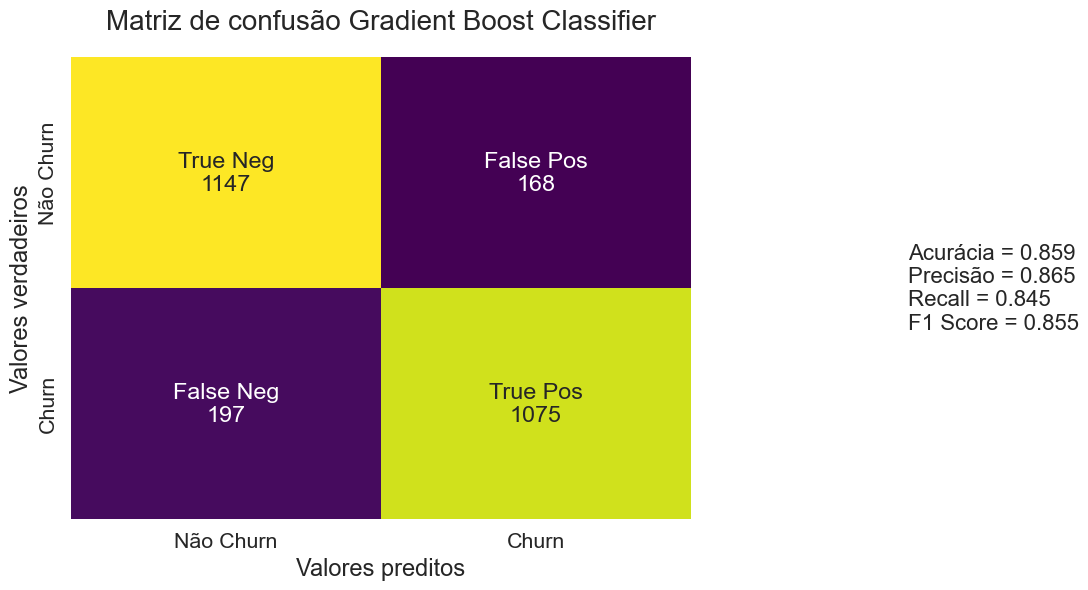

In [137]:
plot_matriz_confusao(y_test, y_pred, group_names=labels, categories=categories, figsize=(8, 6), title='Matriz de confusão Gradient Boost Classifier', cbar=False)


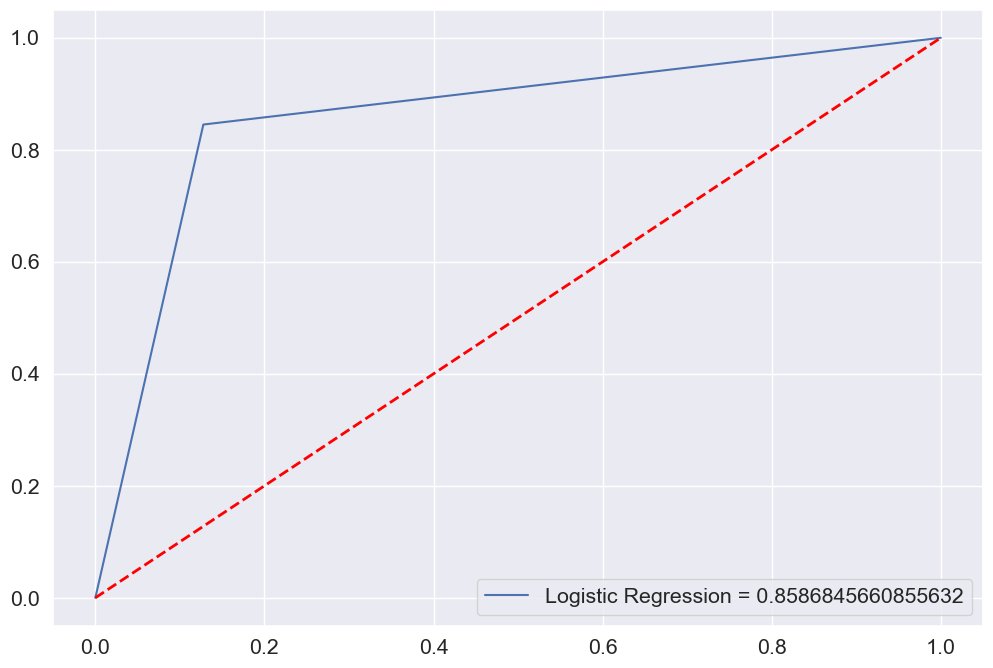

In [140]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'Logistic Regression = ' +str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw=2, linestyle= '--')
plt.legend(loc=4)

Apesar das métricas indicarem o modelo estar dentro do maior valor esperado a curva ROC apresenta uma curva que cresce de maneira bem linear, menos suave, porém com valores de Recall (eixo y) e Precision (eixo x) maiores, confirmado ser um modelo mais adequado para o que se busca nesse desafio.


Por fim, utilizando a biblioteca pickle o modelo gerado será exportado com o formato .pkl para ser utilizado posteriormente.

In [139]:
f1 = f1_score(y_test, y_pred)
nome_modelo = type(best_clf).__name__
path = 'C:\Data-Projects\Alura - Challenge 2 - Novexus\modelos'

f1_str = str(round(f1, 4))

with open(path + nome_modelo + '_f1_' + f1_str + '.pkl', 'wb') as file:
        pickle.dump(best_clf, file)